#Image classification with CNN

In [ ]:
# Importing necessary libraries for deep learning, data manipulation, and model training
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset

import numpy as np
import matplotlib.pyplot as plt

##Data Loading and Preprocessing
This section defines the transformations to be applied to the dataset, such as resizing, converting to tensors, and normalizing. It then loads the MNIST dataset and sets up DataLoaders for training and validation.

In [ ]:
# Data transforming
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(), # pixels in the range of (0,1)
    transforms.Normalize((0.5,), (0.5,)) # pixels in the range of (-1, +1)
])

# Loading MNIST dataset
trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(trainset, batch_size=64, shuffle=True)

valset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
val_loader = DataLoader(valset, batch_size=64, shuffle=False)

## CNN Model Architecture
This section defines the architecture of the Convolutional Neural Network (CNN). The model consists of two convolutional layers followed by max-pooling, two fully connected layers, and ReLU activations with dropout for regularization.




In [ ]:
# Definding a CNN for MNIST classification
class CNNModel(nn.Module):
    def __init__(self):
      super(CNNModel, self).__init__()
      self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
      self.relu1 = nn.ReLU()
      self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
      self.drop1 = nn.Dropout(0.3)

      self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
      self.relu2 = nn.ReLU()
      self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
      self.drop2 = nn.Dropout(0.2)

      self.flatten = nn.Flatten()
      self.fc1 = nn.Linear(64 * 7 * 7, 64)
      self.drop3 = nn.Dropout(0.2)
      self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
      x = self.conv1(x) # input: 28x28x1, output: 28x28x32
      x = self.relu1(x)
      x = self.pool1(x) # input: 28x28x32, output: 14x14x32
      x = self.drop1(x)

      x = self.conv2(x) # input: 14x14x32, output: 14x14x64
      x = self.relu2(x)
      x = self.pool2(x) # input: 14x14x64, output: 7x7x64
      x = self.drop2(x)

      x = self.flatten(x)
      x = self.fc1(x)
      x = self.drop3(x)
      x = self.fc2(x)
      return x

model = CNNModel()

print(model)

CNNModel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.3, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop2): Dropout(p=0.2, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=3136, out_features=64, bias=True)
  (drop3): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)


##How Convolutional Neural Networks Work?


Convolutional neural networks (CNNs) are commonly used for image classification tasks. At a high level, CNNs contain three main types of layers:

- Convolutional layers: Apply convolutional filters to the input to extract features. The neurons in these layers are called filters and capture spatial patterns in the input.
- Pooling layers: Downsample the feature maps from the convolutional layers to consolidate information. Max pooling and average pooling are commonly used strategies.
- Fully-connected layers: Take the high-level features from the convolutional and pooling layers as input for classification. Multiple fully-connected layers can be stacked.

The convolutional filters act as feature detectors, learning to activate when they see specific types of patterns or shapes in the input image. As these filters are applied across the image, they produce feature maps that highlight where certain features are present.

![CNN Building GIF](https://www.kdnuggets.com/wp-content/uploads/awan_building_convolutional_neural_network_pytorch_1.gif)


## Training the Model
## Train the Model
This section sets up the loss function, optimizer, learning rate scheduler, and early stopping mechanism. The loss function used is nn.CrossEntropyLoss, which is suitable for classification tasks, and it is moved to the GPU if available. The optimizer chosen is Adam, which adjusts the learning rate of each parameter dynamically, with a learning rate of 0.001 and a weight decay of 1e-5 to prevent overfitting. The learning rate scheduler (StepLR) reduces the learning rate by a factor of 0.1 every 10 epochs, helping the model converge more efficiently. An early stopping mechanism is also set up to monitor the validation loss and stop training if the model's performance does not improve for 5 consecutive epochs by at least 0.01 (delta).

The training loop runs for a maximum of 100 epochs, where each epoch consists of a training phase and a validation phase. During the training phase, the model is set to training mode using model.train(). The training data is loaded in batches, and each batch is transferred to the GPU if available. The optimizer's gradients are reset with optimizer.zero_grad(), the model's output for the batch is computed, and the loss is calculated using the loss function. The loss is then backpropagated with loss.backward(), and the optimizer updates the model's weights with optimizer.step(). The total training loss for the epoch is accumulated and averaged over the number of batches, and this average loss is stored in the train_losses list.

After the training phase, the validation phase begins with the model set to evaluation mode using model.eval(). Validation data is also processed in batches and transferred to the GPU if available. The model's output for each validation batch is computed without gradient calculation (torch.no_grad()), and the loss is calculated and accumulated. The average validation loss for the epoch is then stored in the val_losses list.

Every 10 epochs, the average training and validation losses are printed to monitor the model's performance. The early stopping mechanism checks the validation loss, and if no significant improvement is detected for 5 consecutive epochs, training is stopped early. The model is then reverted to the best-performing state saved during training.

In [ ]:
# Early Stopping Class
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_loss = np.Inf

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        self.best_loss = val_loss
        torch.save(model.state_dict(), 'checkpoint.pt')

In [ ]:
# Transport model to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Loss functiona, Optimizer and Scheduler
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

# Early stopping instance
early_stopping = EarlyStopping(patience=5, delta=0.001)

In [ ]:
# Lists to store loss values
train_losses = []
val_losses = []
num_epochs=50

for epoch in range(num_epochs):
    model.train() # traim mode
    running_loss = 0.0 # store total loss of the current epoch
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        # gradient = 0
        optimizer.zero_grad()
        # make prediction
        outputs = model(inputs)
        # calculate loss between prediction and label
        loss = criterion(outputs, labels)
        # backpropagation
        loss.backward()
        # update parameters
        optimizer.step()

        # add this batch loss to the current epoch loss
        running_loss += loss.item()

    # adjust learning rate
    scheduler.step()

    # calculate mean loss of the current epoch
    train_loss = running_loss / len(trainloader)
    # add the corrent epoch loss to the list of all epochs loss
    train_losses.append(train_loss)

    val_loss = 0.0 # store total val_loss of the current epoch
    model.eval() # evaluation mode
    with torch.no_grad(): # don't update weights
        for inputs, labels in valloader:
            inputs, labels = inputs.to(device), labels.to(device)
            # make prediction
            outputs = model(inputs)
            # calculate loss between val_prediction and its label
            loss = criterion(outputs, labels)
            # add this batch val_loss to the current epoch val_loss
            val_loss += loss.item()

    # calculate mean va_loss of the current epoch
    val_loss = val_loss / len(valloader)
    # add the corrent epoch val_loss to the list of all epochs val_loss
    val_losses.append(val_loss)

    if epoch % 5 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        model.load_state_dict(torch.load('checkpoint.pt'))
        break

Epoch 1/50, Train Loss: 0.1978, Val Loss: 0.0488
Epoch 6/50, Train Loss: 0.0424, Val Loss: 0.0266
Epoch 11/50, Train Loss: 0.0201, Val Loss: 0.0201
Epoch 16/50, Train Loss: 0.0162, Val Loss: 0.0193
Early stopping


##Plotting Training and Validation Loss
This section plots the training and validation losses over epochs. The plot helps in visualizing how the losses change during training and can provide insights into the model's performance and convergence.

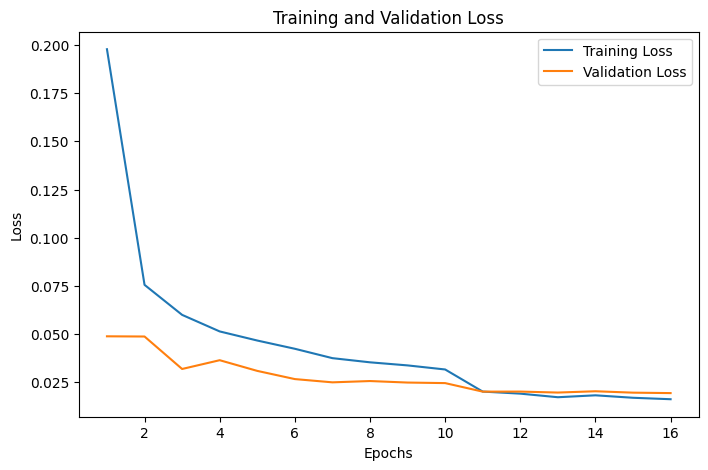

In [ ]:
# Plot the training and validation losses over epochs

# Set the figure size for the plot
plt.figure(figsize=(8, 5))

# Plot the training and validation losses
plt.plot(range(1, 17), train_losses, label='Training Loss')
plt.plot(range(1, 17), val_losses, label='Validation Loss')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

##Visualizing Feature Maps
This section visualizes the feature maps of the first and second convolutional layers. It loads an image from the trainset, passes it through the convolutional layers, and plots the resulting feature maps to provide insights into the learned features.

In [ ]:
# Load an image from the trainset and move to the device
X = trainset.data[5].to(device)
X = X.unsqueeze(0).unsqueeze(0)  # Ensure the shape is [1, 1, 28, 28]
X = torch.tensor(X, dtype=torch.float32)

# Pass through conv1 first to get the correct number of channels
model.eval()
with torch.no_grad():
    feature_maps_conv1 = model.conv1(X)
    feature_maps_conv2 = model.conv2(feature_maps_conv1)

# Move feature maps back to CPU and convert to numpy
feature_maps_conv1 = feature_maps_conv1.cpu().detach().numpy()
feature_maps_conv2 = feature_maps_conv2.cpu().detach().numpy()

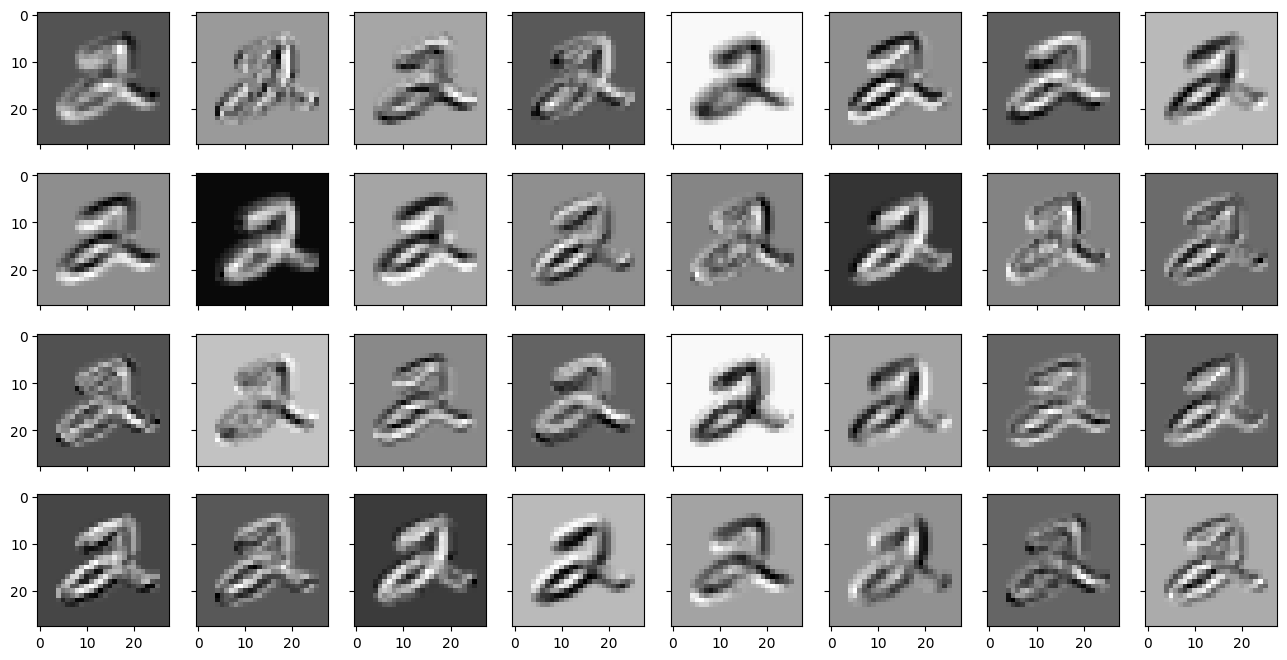

In [ ]:
# Plot the first conv feature maps
fig, ax = plt.subplots(4, 8, sharex=True, sharey=True, figsize=(16, 8))
for i in range(32):
    row, col = i // 8, i % 8
    ax[row][col].imshow(feature_maps_conv1[0][i], cmap='gray')
plt.show()

##Analysis of the First Convolutional Layer Feature Maps
The feature maps obtained from the first convolutional layer provide valuable insights into how the model perceives and processes the input image. Here are some key points we can learn from these feature maps:

**Edge Detection**:
- The first convolutional layer often acts as an edge detector. The feature maps show various edges and gradients present in the input image.
- Some feature maps highlight horizontal edges, while others emphasize vertical or diagonal edges. This indicates that the convolutional filters are learning to identify different orientations of edges in the image.

**Low-Level Features**:
- The feature maps in the first layer capture low-level features such as edges, textures, and simple patterns.
- These low-level features serve as the building blocks for more complex features in the deeper layers of the network.

**Activation Patterns**:
- The different levels of activation in the feature maps (i.e., varying intensities) show which parts of the image are more significant for the filter.
- High activation values indicate regions of the image that are more strongly detected by the corresponding filter.

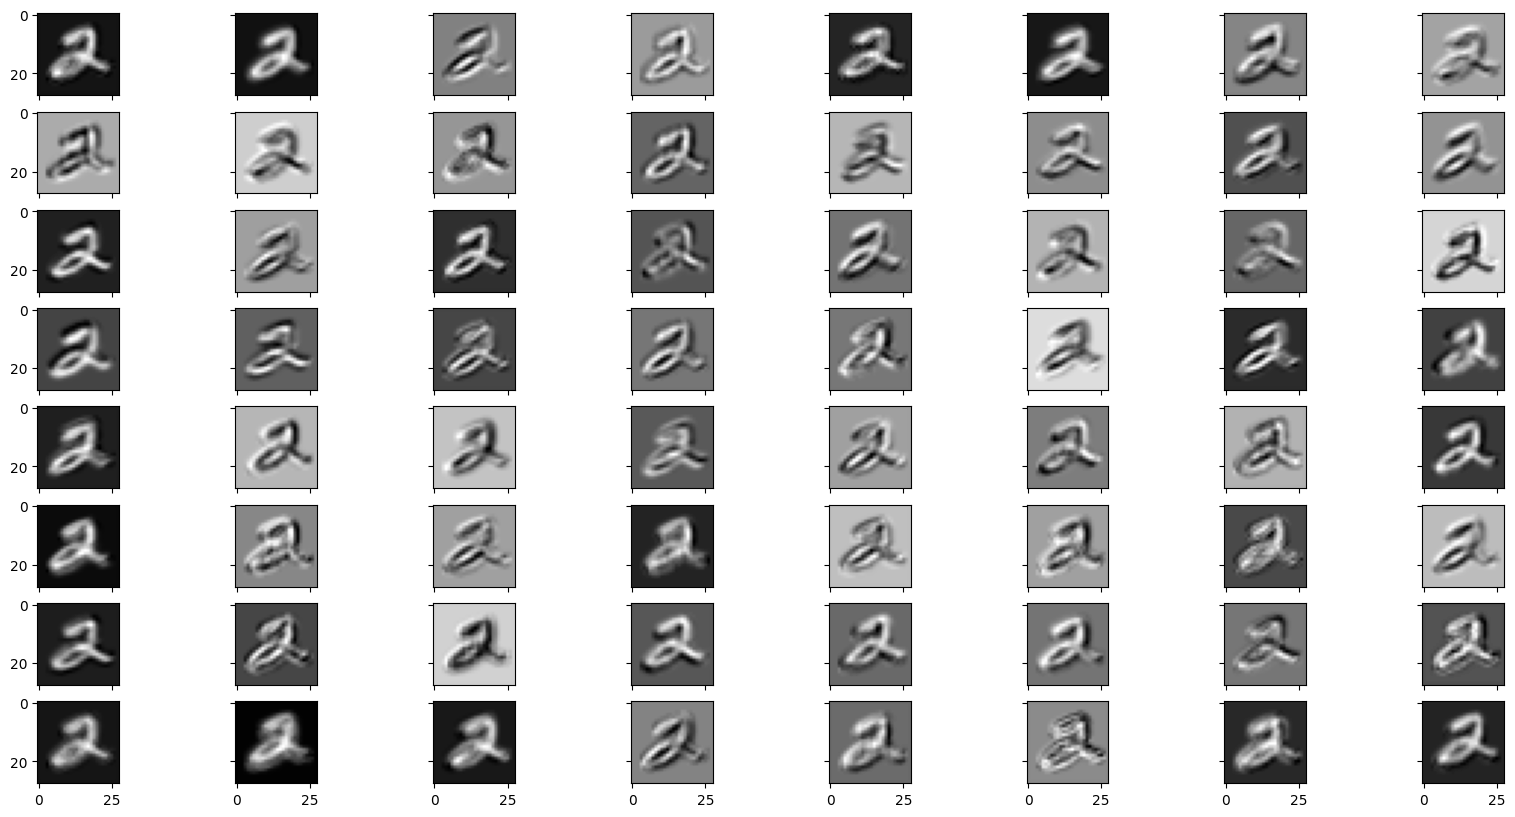

In [ ]:
# Plot the second conv feature maps
fig, ax = plt.subplots(8, 8, sharex=True, sharey=True, figsize=(20, 10))
for i in range(64):
    row, col = i // 8, i % 8
    ax[row][col].imshow(feature_maps_conv2[0][i], cmap='gray')
plt.show()

##Analysis of the Second Convolutional Layer Feature Maps
The feature maps from the second convolutional layer provide deeper insights into how the network processes and understands the input image. Here's what we can learn from these feature maps:

**Higher-Level Features**:
- Unlike the first convolutional layer, which captures basic edges and textures, the second convolutional layer extracts more complex features and patterns from the input image.
- These features might include shapes, contours, and more detailed aspects of the digit.

**Feature Refinement**:
- The second convolutional layer builds on the features extracted by the first layer, refining and combining them to form more detailed and abstract representations.
- This process helps the network understand more intricate details of the input image.

**Filter Specialization**:
- Similar to the first layer, each filter in the second convolutional layer is specialized. However, the specialization is towards more complex patterns compared to the first layer.
- This specialization enables the network to capture a wide range of features necessary for accurate classification.